[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/combine-org/combine-notebooks/main?labpath=%2Fnotebooks%2Fsedml.ipynb)
<a href="https://colab.research.google.com/github/combine-org/combine-notebooks/blob/main/notebooks/sedml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

# Simple SBOL example

This notebook creates a simple model in [Synthetic Biology Open Language (SBOL) Version 3.0.1](https://sbolstandard.org/docs/SBOL3.0.1.pdf). SBOL is a free and open-source standard for the representation of biological designs. SBOL uses existing Semantic Web practices and resources, such as Uniform Resource Identifiers (URIs) and ontologies, to unambiguously identify and define genetic design elements. In this notebook we will be creating a simple sequence based on this [notebook](https://github.com/RudgeLab/LOICA/blob/master/notebooks/LOICA_DEMO_Operators.ipynb). We then create a diagram of the sequence (see below) using the SBOL Visual standard. SBOL Visual aims to organize and systematize conventions in order to produce a coherent language for expressing the structure and function of genetic designs.

<center>
<img src="./results/hello_world_sbol_visual.png" alt="SBML Simulation Plot">
</center>

## 1) Including libraries and setup

Note: the cell below runs some code to determine where the notebook is running (e.g. on your local machine or on Binder), and decides where to save results. If it is hidden, click on the dots (•••) to view.

In [1]:
#note: metadata hides this cell on binder but it doesn't get hidden on colab
from pathlib import Path

#determine if we're running on colab
try:
  import google.colab
  exec_env = "colab"      #we seem to be on colab
  print("Assuming this notebook is running on Google Colab")
except:
  exec_env = "binder"     #assume it's binder

if exec_env == "colab":
  working_dir = f"{Path.cwd()}/combine-notebooks/notebooks/results"
  !git clone https://github.com/combine-org/combine-notebooks
  %cd combine-notebooks
  !pip install .
  %mkdir -p {working_dir}

else:
  #binder starts off in the notebook's folder
  working_dir = f"{Path.cwd()}/results"

import os
os.chdir(working_dir)

print("Results will be saved in %s"%working_dir)

Results will be saved in /Users/padraig/git/combine-notebooks/notebooks/results


In [2]:
from pathlib import Path

import sbol3
from sbol_utilities import component
import parasbolv as psv
import matplotlib.pyplot as plt

RESULTS_DIR =  Path(working_dir) # determined based on the running environment above
from combine_notebooks import GLYPH_DIR

%matplotlib inline

## 2) Declaring the SBOL model

A valid SBOL Document with the sequences and parts that we will use in the design. Here we create the J23101 Operator as an Engineered Region composed by the promoter J23101 and the BASIC RBS1 (derived from BBa_B0033). We create the GFP GeneProduct also as an Engineering Region now composed by GFP CDS, M0050 degradation tag and rrnbT1 terminator. First, we will decalre the SBOL document and set the namespace.

In [3]:
doc = sbol3.Document()
sbol3.set_namespace('https://github.com/Gonza10V')

Next, we will create a promoter.  A synthetic promoter is a sequence of DNA that does not exist in nature and which has been designed to control gene expression of a target gene.

In [4]:
j23101, j23101_seq = component.promoter('J23101','tttacagctagctcagtcctaggtattatgctagc ', description='https://synbiohub.org/public/igem/BBa_J23101/1')

Now, we will create a ribosome binding site (RBS), which is a sequence of nucleotides upstream of the start codon of an mRNA transcript that is responsible for the recruitment of a ribosome during the initiation of translation.

In [5]:
rbs1, rbs1_seq = component.rbs('RBS1', 'ttgaacaccgtcTCAGGTAAGTATCAGTTGTAAatcacacaggacta', description='BASIC Linker RBS1')

Define the promoter and RBS as our first engineered region.

In [6]:
op_j23101 = component.engineered_region('operator_ptet', [j23101,rbs1], description= 'LOICA Operator J23101')

The next step is to create a CoDing Sequence (CDS).  This is a region of DNA or RNA whose sequence determines the sequence of amino acids in a protein.

In [7]:
gfpm3, gfpm3_seq = component.cds('GFP_mut3', 'atgcgtaaaggagaagaacttttcactggagttgtcccaattcttgttgaattagatggtgatgttaatgggcacaaattttctgtcagtggagagggtgaaggtgatgcaacatacggaaaacttacccttaaatttatttgcactactggaaaactacctgttccatggccaacacttgtcactactttcggttatggtgttcaatgctttgcgagatacccagatcatatgaaacagcatgactttttcaagagtgccatgcccgaaggttatgtacaggaaagaactatatttttcaaagatgacgggaactacaagacacgtgctgaagtcaagtttgaaggtgatacccttgttaatagaatcgagttaaaaggtattgattttaaagaagatggaaacattcttggacacaaattggaatacaactataactcacacaatgtatacatcatggcagacaaacaaaagaatggaatcaaagttaacttcaaaattagacacaacattgaagatggaagcgttcaactagcagaccattatcaacaaaatactccaattggcgatggccctgtccttttaccagacaaccattacctgtccacacaatctgccctttcgaaagatcccaacgaaaagcgcgaccacatggtccttcttgagtttgtaacagctgctgggattacacatggcatggatgaactatacaaa', description='GFP mut3 Coding Sequence, no BsaI site, no stop codon')

Next, we add a sequence that will ensure the resultant protein susceptible to very fast degradation.

In [8]:
m0050, m0050_seq = component.protein_stability_element('M0050', 'gctgctaacgacgaaaactacgctctggctgctTAAattgaacta', description='http://parts.igem.org/wiki/index.php?title=Part:BBa_M0050')

Finally, we will create a terminator sequence. Terminators are genetic parts that usually occur at the end of a gene or operon and cause transcription to stop.

In [9]:
ter1, ter1_seq = component.terminator('TER1', 'GTCCatttgtcctactcaggagagcgttcaccgacaaacaacagataaaacgaaaggcccagtctttcgactgagcctttcgttttatttgTAAGGCTCG', description='rrnB T1 terminator from Potvin-Trottier pLPT119, extra stop codon')

Define the CDS, stability element, and terminator as our second engineered region.

In [10]:
gp_gfp = component.engineered_region(f'geneproduct_{gfpm3.display_id}_{m0050.display_id}_{ter1.display_id}', [gfpm3, m0050, ter1], description='LOICA GeneProduct GFP')

Add everything we have just created to the SBOL document.

In [11]:
doc.add([j23101, j23101_seq, rbs1, rbs1_seq, op_j23101, gfpm3, gfpm3_seq, m0050, m0050_seq, ter1, ter1_seq, gp_gfp])

## 3) Validate, save and display SBOL document

Print out all object identities in the SBOL document.  Then validate the document.

In [12]:
for obj in doc.objects:
    print(obj.identity)
report_sbol3 = doc.validate()
print(len(report_sbol3))

https://github.com/Gonza10V/J23101
https://github.com/Gonza10V/J23101_seq
https://github.com/Gonza10V/RBS1
https://github.com/Gonza10V/RBS1_seq
https://github.com/Gonza10V/operator_ptet
https://github.com/Gonza10V/GFP_mut3
https://github.com/Gonza10V/GFP_mut3_seq
https://github.com/Gonza10V/M0050
https://github.com/Gonza10V/M0050_seq
https://github.com/Gonza10V/TER1
https://github.com/Gonza10V/TER1_seq
https://github.com/Gonza10V/geneproduct_GFP_mut3_M0050_TER1
0


We can save this SBOL as an XML file which is in RDF format. An RDF file is a document written in the Resource Description Framework (RDF) language, which is used to represent information about resources on the web. As you can see in the text, most tags are pointing to a specific URI on the internet.

In [13]:
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
sbol_file = RESULTS_DIR / 'hello_world_sbol.xml'
doc.write(sbol_file)
with open(sbol_file) as f:
   print(f.read())

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:sbol="http://sbols.org/v3#"
>
  <rdf:Description rdf:about="https://github.com/Gonza10V/operator_ptet">
    <sbol:displayId>operator_ptet</sbol:displayId>
    <sbol:description>LOICA Operator J23101</sbol:description>
    <rdf:type rdf:resource="http://sbols.org/v3#Component"/>
    <sbol:hasNamespace rdf:resource="https://github.com/Gonza10V"/>
    <sbol:type rdf:resource="https://identifiers.org/SBO:0000251"/>
    <sbol:role rdf:resource="https://identifiers.org/SO:0000804"/>
    <sbol:hasFeature rdf:resource="https://github.com/Gonza10V/operator_ptet/SubComponent1"/>
    <sbol:hasFeature rdf:resource="https://github.com/Gonza10V/operator_ptet/SubComponent2"/>
    <sbol:hasConstraint rdf:resource="https://github.com/Gonza10V/operator_ptet/Constraint1"/>
  </rdf:Description>
  <rdf:Description rdf:about="https://github.com/Gonza10V/TER1_seq">
    <sbol:displayId>TER1_seq<

## 4) SBOL Visual

In this section we will be using the [SBOL visual standard](https://sbolstandard.org/docs/SBOL-Visual-3.0.pdf). SBOL Visual aims to organize and systematize such conventions in order to produce a coherent language for expressing the structure and function of genetic designs. At the same time, it aim to make this language simple and easy to use, allowing a high degree of flexibility and freedom in how such diagrams are organized, presented, and styled—in particular, it is easy to create diagrams either by hand or using a wide variety of software programs.

We will be using the paraSBOLv library to draw a simple diagram.  SBOL visual is made up of glyphs, each of which will correspond to something in SBOL.  Below we will create four glyphs in isolation, then we will chain them together to create a model similar to the above SBOL model.

Firstly, we will create an object to render the glyths.

In [14]:
renderer = psv.GlyphRenderer()
renderer = psv.GlyphRenderer(glyph_path = str(GLYPH_DIR))

This glyth is a promoter. It is created using the `renderer.draw_glyph` function.

(0.0, 20.0)

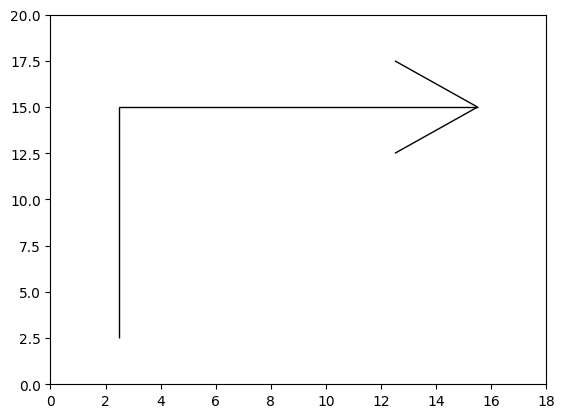

In [15]:
fig, ax = plt.subplots()
bounds, end_point = renderer.draw_glyph(ax, 'Promoter', (2.5, 2.5))

ax.set_xlim([bounds[0][0] - 2.5, bounds[1][0] + 2.5])
ax.set_ylim([bounds[0][1] - 2.5, bounds[1][1] + 2.5])


This glyth is a ribosome entry site.

(0.0, 15.000000000000004)

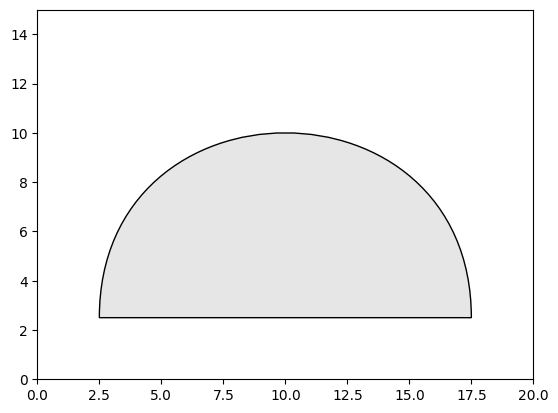

In [16]:
fig, ax = plt.subplots()
bounds, end_point = renderer.draw_glyph(ax, 'RibosomeEntrySite', (2.5, 2.5))

ax.set_xlim([bounds[0][0] - 2.5, bounds[1][0] + 2.5])
ax.set_ylim([bounds[0][1] - 2.5, bounds[1][1] + 2.5])

This glyth is a CoDing Sequence (CDS).

(-7.5, 12.5)

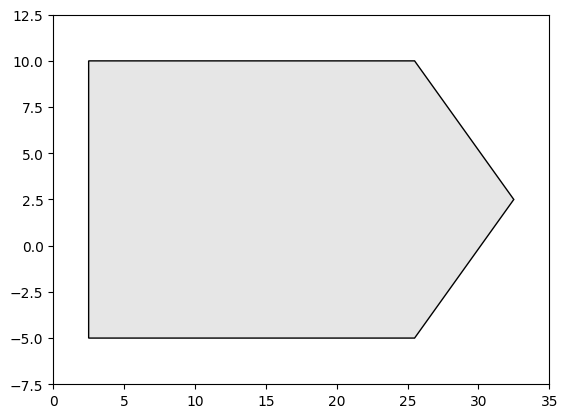

In [17]:
fig, ax = plt.subplots()
bounds, end_point = renderer.draw_glyph(ax, 'CDS', (2.5, 2.5))

ax.set_xlim([bounds[0][0] - 2.5, bounds[1][0] + 2.5])
ax.set_ylim([bounds[0][1] - 2.5, bounds[1][1] + 2.5])

This glyph is a terminator.

(0.0, 15.0)

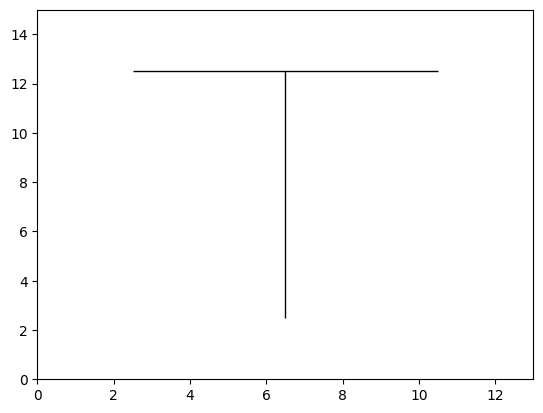

In [18]:
fig, ax = plt.subplots()
bounds, end_point = renderer.draw_glyph(ax, 'Terminator', (2.5, 2.5))

ax.set_xlim([bounds[0][0] - 2.5, bounds[1][0] + 2.5])
ax.set_ylim([bounds[0][1] - 2.5, bounds[1][1] + 2.5])

Now we will combine these into a single sequence. Starting with a promoter, ending with a terminator, and containing both ribosome entry site and CDS components in between.

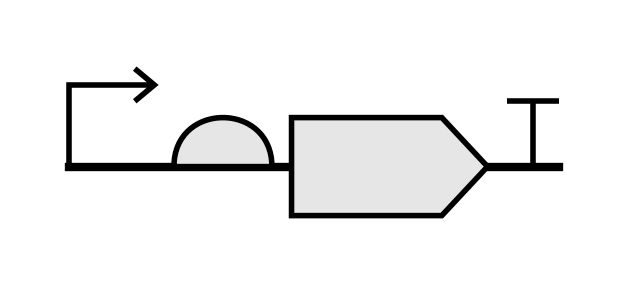

In [19]:
from collections import namedtuple
from matplotlib.pyplot import figure

part_list = []
Part = namedtuple('part', ['glyph_type', 'orientation',  'user_parameters', 'style_parameters'])
part_list.append(Part('Promoter', 'forward', None, None))
part_list.append(Part('RibosomeEntrySite', 'forward', None, None))
part_list.append(Part('CDS', 'forward', None, None))
part_list.append(Part('Terminator', 'forward', None, None))

construct = psv.Construct(part_list, renderer)

fig, ax, baseline_start, baseline_end, bounds = construct.draw(False)
fig.dpi = 400

ax.plot([baseline_start[0], baseline_end[0]], [baseline_start[1], baseline_end[1]], color=(0,0,0), linewidth=1.5, zorder=0)

plt.savefig(str(RESULTS_DIR / 'hello_world_sbol_visual.png'))